# Assignment 5 - Policy Gradient Methods

<div class="alert alert-warning">

**Due:** See MOODLE
</div>


<div class="alert alert-info">
    
In this assignment we will solve the Cartpole balancing problem using the **Policy Gradient Method REINFORCE**.<br>

In particular we will use a neural network to approximate our policy $\pi(a|s)$. To that end we will rely on an auto-differentiation framework which will provide us with the gradients of our policy with respect to its parameters.

You will use the **PyTorch** framework for this exercise: `$ conda install pytorch cpuonly -c pytorch`<br>

To accomplish this exercise read the notebook carefully from beginning to end. Fill out to coding parts marked with **TODO**.<br>
Please also **provide comments in your code** to make it is easier for us to understand how it all fits together.
</div>

In [1]:
import gym
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.distributions import Categorical
from torch.nn.init import calculate_gain

### A helper function to convert seeds from a seed sequence to python `int`s:

In [2]:
def seed_adapter(seed_sequence):
    # spawn a new child generator from the seed_sequence
    child = seed_sequence.spawn(1)[0]

    # generate a random seed
    seed_uint64 = child.generate_state(1, np.uint64)[0]

    # torch and the numpy PRNGs used in the openai gym want a python 'int', not a 'numpy.uint64'!
    seed_int = int(seed_uint64)

    print('seed_int', seed_int)
    return seed_int

### Some helper functions to initialize the weights of neural networks:

In [3]:
def relu_init(m):
    # print('relu_init', m)
    nn.init.kaiming_normal_(
        m.weight.data, 0.,
        mode='fan_in',
        nonlinearity='relu'
    )
    nn.init.constant_(m.bias.data, 0.)


def linear_init(m):
    # print('linear_init', m)
    nn.init.kaiming_normal_(
        m.weight.data, 0.,
        mode='fan_in',
        nonlinearity='linear'
    )
    nn.init.constant_(m.bias.data, 0.)


def softmax_init(m):
    # print('softmax_init', m)
    nn.init.xavier_normal_(m.weight.data, calculate_gain('sigmoid'))
    nn.init.constant_(m.bias.data, 0.)

### Neural network definitions for a policy $\pi_{\Theta}(a | s)$, and a state value function $V_{\Phi}(s)$:

In [4]:
class PolicyNet(nn.Module):
    def __init__(self, n_in, n_out):
        super(PolicyNet, self).__init__()
        n_hidden = 128
        self.net = nn.Sequential(
            nn.Linear(n_in, n_hidden),
            nn.ReLU(inplace=False),
            nn.Linear(n_hidden, n_out),
            nn.Softmax(dim=1)
        )
        relu_init(self.net[0])
        softmax_init(self.net[2])

    def forward(self, x):
        return self.net(x)


class ValueNet(nn.Module):
    def __init__(self, n_in, n_out):
        super(ValueNet, self).__init__()
        n_hidden = 128
        self.net = nn.Sequential(
            nn.Linear(n_in, n_hidden),
            nn.ReLU(inplace=False),
            nn.Linear(n_hidden, n_out),
        )
        relu_init(self.net[0])
        linear_init(self.net[2])

    def forward(self, x):
        return self.net(x)

### Helper function to compute (standardized) returns:

In [5]:
def compute_returns(rewards, gamma):
    returns = []
    G = 0
    for r in rewards[::-1]:
        G = r + gamma * G
        returns.insert(0, G)
    
    # this is a trick that is often used, when we
    # use function approximators to learn values
    # or policies: the returns are standardized to
    # have a mean value of 0, and a stddev of 1.
    # this has a stabilizing effect on training.
    returns = np.array(returns)
    returns = returns - returns.mean()
    returns = returns / returns.std()
    return returns

### A helper function that visualizes an episode:
We'll see after the definition of agent, how to use this.

In [6]:
def visualize_episode(gamma, episode, losses=dict()):
    states = np.array(episode['states'])
    actions = np.array(episode['actions'])
    rewards = np.array(episode['rewards'])
    
    if 'values' in episode:
        values = torch.cat(episode['values']).squeeze().detach().numpy()
    else:
        values = np.full_like(rewards, np.nan, dtype=float)

    if len(losses) > 0 and 'policy_losses' in losses:
        p_losses = losses['policy_losses'].detach().numpy()
    else:
        p_losses = np.full_like(rewards, np.nan, dtype=float)
        
    if len(losses) > 0 and 'value_losses' in losses:
        v_losses = losses['value_losses'].detach().numpy()
    else:
        v_losses = np.full_like(rewards, np.nan, dtype=float)

    returns = compute_returns(episode['rewards'], gamma)

    deltas = returns - values
    linestyle = '-'

    fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(16, 6), sharex=True)
    ax = axes[0, 0]
    ax.set_title('states')
    ax.plot(states[:, 0], linestyle=linestyle, marker='.', label='cart position')
    ax.plot(states[:, 1], linestyle=linestyle, marker='.', label='cart velocity')
    ax.plot(states[:, 2], linestyle=linestyle, marker='.', label='pole angle')
    ax.plot(states[:, 3], linestyle=linestyle, marker='.', label='pole angular velocity')
    ax.legend()
    

    ax = axes[0, 1]
    ax.set_title('actions (from policy net)')
    ax.set_yticks([0, 1])
    ax.set_yticklabels(['left', 'right'])
    ax.set_ylim([-0.1, 1.1])
    ax.plot(actions, linestyle=' ', marker='.')

    ax = axes[1, 0]
    ax.set_title('rewards')
    ax.set_yticks([0, 1])
    ax.set_ylim([-0.1, 1.1])
    ax.plot(rewards, linestyle=linestyle, marker='.')

    ax = axes[1, 1]
    ax.set_title('values vs. returns')
    ax.plot(values, linestyle=linestyle, marker='.', label='values')
    ax.plot(returns, linestyle=linestyle, marker='x', label='returns')
    ax.legend()

    ax = axes[2, 0]
    ax.set_title('policy & value losses')
    ax.plot(p_losses, linestyle=linestyle, marker='.', label='policy loss')
    ax.plot(v_losses, linestyle=linestyle, marker='.', label='value loss')
    ax.legend()

    ax = axes[2, 1]
    ax.set_title('deltas (returns - values)')
    ax.plot(deltas, linestyle=linestyle, marker='.')

    for ax in axes.flatten():
        h = len(states) // 2
        m = len(states)
        ax.set_xticks([0, h, m])

    # all axes in the bottom row
    for ax in axes[-1, :].flatten():
        ax.set_xlabel('timestep t')
    plt.tight_layout()
    plt.show()

## The class definition of the REINFORCE agent
This is a partial definition of an RL agent that is supposed to implement the REINFORCE algorithm. You will implement the agent step-by-step. Look at the TODOs, and the later cells, and follow each step. At the end of each step, you should have a fully functional agent, that is able to learn to balance a pole on a cart.

In [7]:
class REINFORCEAgent():
    def __init__(self, env, alpha):
        self.n_actions = env.action_space.n
        self.n_observation = list(env.observation_space.shape)[0]

        self.policy = PolicyNet(self.n_observation, self.n_actions)
        self.optimizer = optim.Adam(
            self.policy.parameters(),
            lr=alpha,
        )

    def get_action_and_log_prob(self, state):
        # get the state as a pytorch tensor, bring it into the right format
        state = torch.from_numpy(state).float().unsqueeze(0)
        
        
        # TODO
        # use the policy network to get the distribution pi(a | s), and
        # sample an action from this distribution
        # hint: (use the 'Categorical' distribution class in pytorch)
        instance_pol_net = self.policy
        
        pol_for_state = instance_pol_net.forward(state) # returns action-selection PROBABILITIES
        
        # choose action:
        cate_obj = Categorical(pol_for_state)
        action = cate_obj.sample() # take action randomly based on the probability distribution
        

        # TODO
        # return both the sampled action, and its log probability
        # hint: (use the the same 'Categorical' distribution object you used to sample the action)
        log_prob_of_action = cate_obj.log_prob(action)

        return action.item(), log_prob_of_action

    def generate_episode(self, env):
        states = []
        actions = []
        log_probs = []
        rewards = []

        done = False
        state = env.reset()
        
        # TODO
        # here, you'll interact with the episodic environment, and generate
        # an episode. use the method 'self.get_action_and_logprob' you implemented above!
        # you will need to record for later:
        # - a list of states
        # - a list of actions
        # - a list of the log probabilities of the actions
        # - a list of rewards

        while not done:
            action, log_prob = self.get_action_and_log_prob(state)
            
            states.append(state), actions.append(action), log_probs.append(log_prob)
            
            state, reward, done, _ = env.step(action) # for what is _???????????
            rewards.append(reward)
            
            # From Lecture 08_policy_gradient_methods slide 33:
            # if len(rewards) == 200: # episode also ends after 200 steps
            #   done = True
            # However, I commented it out because in '### Making sure REINFORCE learns something useful'
            # I wouldn't get the same as in the exhibited solution. The reason is that mine couldn't 
            # collect more than 200 reward for each episode because an episode ends after 200 steps and
            # for each step we would get a reward of 1.
            

        return dict(
            states=states,
            actions=actions,
            rewards=rewards,
            log_probs=log_probs
        )

    def update(self, episode, gamma):
        # TODO: compute returns by calling `compute_returns(rewards, gamma)`, as it
        # already includes the return standardization
        
        dictionary = episode # self.generate_episode(env)
        
        G_list = compute_returns(dictionary['rewards'], gamma)
        
    
        # use this list to keep track of the loss terms at the individual steps
        policy_losses = []

        # TODO: loop through the episode, compute the loss terms for the individual steps
        #
        # please note, that the pseudo code in the book/on the slides gives the vanilla SGD
        # update rule already. what you need to do now, is to specify individual loss terms for
        # each step. these loss terms need to lead to the desired gradients, when we use
        # `policy_loss.backward()` later on.
        # append each individual loss term to the list `policy_losses`
        #
        # please also note that each individual loss term needs to include the `gamma ** t` term
        # from the REINFORCE pseudo code given in the book, page 328!
    
        
        time_t = 0
        
        for log_prob, G_t in zip(dictionary['log_probs'], G_list):
            
            # for each time step we have a loss:
            policy_loss1 = - gamma**time_t * G_t * log_prob
            
            policy_losses.append(policy_loss1)
            
            time_t += 1
            
            
        # -----------------------------------------------------------------------------------
        # --- the code below does not need to be changed ------------------------------------
        # -----------------------------------------------------------------------------------
        # this resets the gradients on all involved weight tensors
        self.optimizer.zero_grad()

        # this concatenates all individual policy loss terms
        policy_losses = torch.cat(policy_losses)
        
        # here we sum all policy losses up. this implements the gradient accumulation
        # "theta = theta + ..." from the pseudo code, where it says
        # "loop for each step of the episode ..." in one neat line.
        policy_loss = policy_losses.sum()

        # this computes the gradient of the loss wrt all involved weight tensors
        policy_loss.backward()

        # this updates the weight tensors with the update rule of the optimizer
        # we're not using vanilla SGD here, but rather the Adam update rule,
        # as it converges much, much faster
        self.optimizer.step()
        
        # finally, we'll return the policy_loss for visualization purposes later on
        return dict(
            policy_loss=policy_loss.item(),
            policy_losses=policy_losses
        )

## (1) Implement action selection (1 point)
The first thing you will need to do is to implement action selection with a <b>parametrized policy</b>. Look at `get_action_and_log_prob(self, state)`, implement all the `TODO`s, and then try to execute the code cell below:

In [8]:
gamma = 0.99
seed_sequence = np.random.SeedSequence(1)

env = gym.make('CartPole-v1')

env.seed(seed_adapter(seed_sequence))
torch.manual_seed(seed_adapter(seed_sequence))

agent = REINFORCEAgent(env, alpha=1e-3)

# let's get the starting state of the environment
state = env.reset()

# now we'll test the action selection method
action, log_prob = agent.get_action_and_log_prob(state)

# this should be an integer
print('action:', action, type(action))

# and this should be a torch tensor with a 'grad_fn' field
print('log_prob:', log_prob, type(log_prob))

seed_int 8431846347943309920
seed_int 4042681867674859579
action: 0 <class 'int'>
log_prob: tensor([-0.7008], grad_fn=<SqueezeBackward1>) <class 'torch.Tensor'>


### The expected output of the previous cell should look exactly like this:
```
seed_int 8431846347943309920
seed_int 4042681867674859579
action: 0 <class 'int'>
log_prob: tensor([-0.7008], grad_fn=<SqueezeBackward1>) <class 'torch.Tensor'>
```

## (2) Implement episode generation (1 points)
Now that we can select an action, given a state, let's see if we can generate an episode. Look at `generate_episode(self, env)`, implement all the `TODO`s, and then try to execute the code cell below.<br>

**When you are debugging, keep the possibility to visualize episodes (and later on losses as well) in mind!**

seed_int 3890642289391122579
seed_int 13194552230369835111


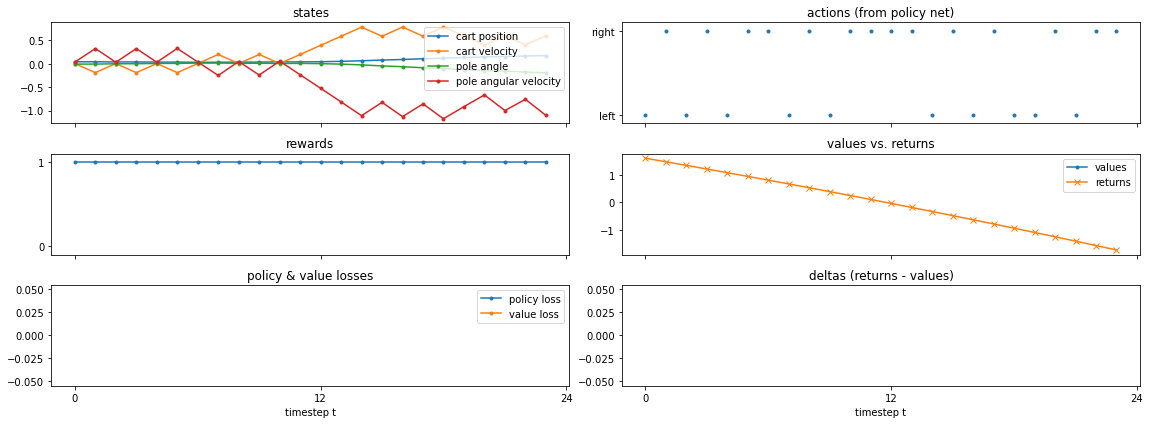

In [9]:
gamma = 0.99
seed_sequence = np.random.SeedSequence(2)

env = gym.make('CartPole-v1')

env.seed(seed_adapter(seed_sequence))
torch.manual_seed(seed_adapter(seed_sequence))

agent = REINFORCEAgent(env, alpha=1e-3)
episode = agent.generate_episode(env)

visualize_episode(gamma, episode)

### The expected output of the previous cell should look exactly like this:
```
seed_int 3890642289391122579
seed_int 13194552230369835111
```
<img src='expected_episode_generation_output.png'/>

## (3) Implement the REINFORCE update (4 points)
Now that we made sure we can generate an episode, your next task is to implement the REINFORCE update. Look at `update(self, episode, gamma)`, implement all the `TODO`s, and then try to execute the code cell below.

seed_int 14449357594836781232
seed_int 18443715169928553612


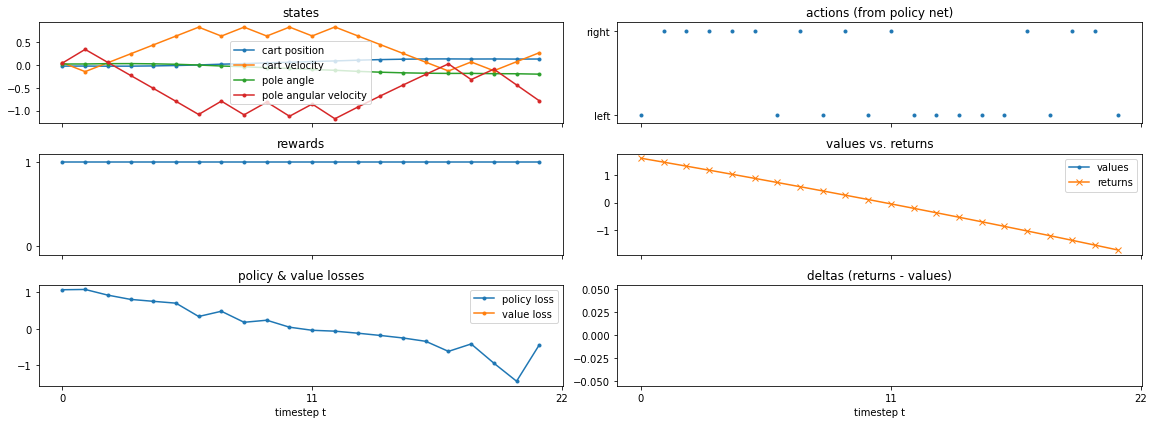

In [10]:
gamma = 0.99
seed_sequence = np.random.SeedSequence(3)

env = gym.make('CartPole-v1')

env.seed(seed_adapter(seed_sequence))
torch.manual_seed(seed_adapter(seed_sequence))

agent = REINFORCEAgent(env, alpha=1e-3)
episode = agent.generate_episode(env)
losses = agent.update(episode, gamma)
visualize_episode(gamma, episode, losses)

### The expected output of the previous cell should look exactly like this:
```
seed_int 14449357594836781232
seed_int 18443715169928553612
```
<img src='expected_update_output.png'/>

### Making sure REINFORCE learns something useful
If you could reproduce the updates above, your implementation should already be useful, and learn a somewhat useful agent.<br>
Let's train it for 200 episodes, and see what it has learned.

seed_int 16363712187084821697
seed_int 7001527192274380292


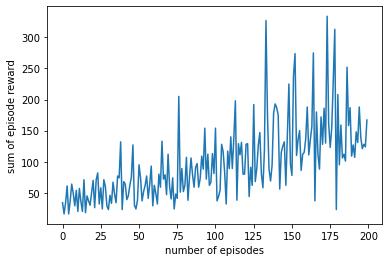

In [11]:
gamma = 0.99
seed_sequence = np.random.SeedSequence(4)

env = gym.make('CartPole-v1')
env.seed(seed_adapter(seed_sequence))

torch.manual_seed(seed_adapter(seed_sequence))
agent = REINFORCEAgent(env, alpha=1e-3)

episode_rewards = []
for i_episode in range(200):
    episode = agent.generate_episode(env)
    losses = agent.update(episode, gamma)
    episode_rewards.append(np.sum(episode['rewards']))

fig, ax = plt.subplots()
ax.set_ylabel('sum of episode reward')
ax.set_xlabel('number of episodes')
ax.plot(episode_rewards)
plt.show()

### The expected output of the previous cell should look exactly like this:
```
seed_int 16363712187084821697
seed_int 7001527192274380292
```
<img src='expected_train_rewards.png'/>

### Let's look at a generated episode, after the agent has trained for 200 episodes:

seed_int 14449357594836781232
seed_int 18443715169928553612


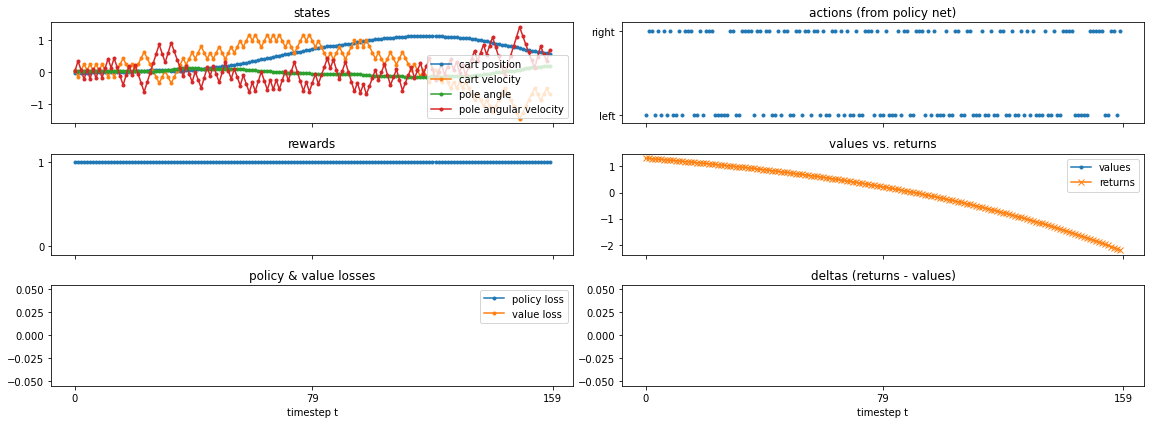

In [12]:
seed_sequence = np.random.SeedSequence(3)

env = gym.make('CartPole-v1')
env.seed(seed_adapter(seed_sequence))

# this needs to be set before generating an episode, as it governs the sampling happening in the `Categorical` distribution
torch.manual_seed(seed_adapter(seed_sequence))
episode = agent.generate_episode(env)
visualize_episode(gamma, episode)

## (5) Computational experiments with REINFORCE (2 points)
You will now have to run a small set of computational experiments with your REINFORCE implementation. You will have a look at three different parameterizations of the learning rate `alpha` (see below).<br>

We'll define a helper function first, that does a lot of the boring steps for you already. It takes in a `SeedSequence` for reproducibility, a discount factor `gamma`, the number of runs `n_runs`, and the number of episodes per run `n_episodes`.<br>

Furthermore it takes a type `agent_class`, and a dictionary `agent_params`, so it can instantiate a new agent for each run.<br>

`log_interval` specifies how often an intermediate result is displayed.

In [13]:
# a helper function that runs computational experiments
def run_experiments(seed_sequence,
                    env,
                    gamma,
                    n_runs,
                    n_episodes,
                    agent_class,
                    agent_params,
                    log_interval=50):
    print('-' * 60)
    print('agent_class', agent_class)
    print('agent_params', agent_params)
    env.seed(seed_adapter(seed_sequence))
    torch.manual_seed(seed_adapter(seed_sequence))

    import sys
    run_rewards = []
    for i_run in range(n_runs):
        # at the start of each run, we instantiate a new agent
        agent = agent_class(**agent_params)
        episode_rewards = []
        for i_episode in range(n_episodes):
            episode = agent.generate_episode(env)
            losses = agent.update(episode, gamma)
            episode_rewards.append(np.sum(episode['rewards']))
            
            # "make sure we can watch optimizer TV", i.e. display progress, and
            # do some fancy logging, so that we have the feeling that something
            # is happening, while we are waiting ... :)
            if i_episode % log_interval == 0 or i_episode == n_episodes - 1:
                out = f'run:{i_run}/{n_runs} ep:{i_episode:>04d}/{n_episodes} '
                for name, value in losses.items():
                    if name.endswith('_loss'):
                        out += f'{name}:{value:04.2f} '
                out += f'avg reward last 10 episodes:{np.mean(episode_rewards[-10:])}'
                
                # overwrite what's already been written
                sys.stdout.write('\r' + ' ' * 400)
                # write 'out' to stdout
                sys.stdout.write(f'\r{out}')
                sys.stdout.flush()

        run_rewards.append(episode_rewards)
    print()
    # this returns an array with the sum of rewards for each episode.
    # it is shaped like this: (n_runs, n_episodes)
    return np.array(run_rewards)

# a helper function for plotting later on
def plot(ax, rewards, label):
    mean_rewards = np.mean(rewards, axis=0)
    std_rewards = np.std(rewards, axis=0)
    ax.fill_between(
        np.arange(rewards.shape[1]),
        np.maximum(1, mean_rewards - std_rewards),    # sums smaller than 1 are impossible
        np.minimum(500, mean_rewards + std_rewards),  # sums larger than 500 are impossible
        alpha=0.4  # this specifies transparency of the area that's filled in
    )
    ax.plot(mean_rewards, label=label)

### Run three experiments
You will now run three computational experiments, each with a different learning rate `alpha`. The alphas are already given in the code cell below.<br>

Use the function `run_experiments`, and collect the `run_rewards` for each run produced by a different learning rate. You'll need to plot these in the next step.

In [14]:
gamma = 0.99
seed_sequence = np.random.SeedSequence(5)

env = gym.make('CartPole-v1')

n_runs = 5
n_episodes = 200
alphas = [1e-4, 1e-3, 1e-2]

# TODO: run three separate experiments, one with each alpha specified above
run_rewards = dict()
for alpha in alphas:
    run_rewards[alpha] = run_experiments(
        seed_sequence,  # reusing this makes sure each run has a different seed
        env,
        gamma,
        n_runs,
        n_episodes,
        REINFORCEAgent,
        agent_params=dict(
            env=env,
            alpha=alpha
        )
    )

------------------------------------------------------------
agent_class <class '__main__.REINFORCEAgent'>
agent_params {'env': <TimeLimit<CartPoleEnv<CartPole-v1>>>, 'alpha': 0.0001}
seed_int 15658875773272509128
seed_int 6924645418555453511
run:4/5 ep:0199/200 policy_loss:0.34 avg reward last 10 episodes:16.1                                                                                                                                                                                                                                                                                                                                           
------------------------------------------------------------
agent_class <class '__main__.REINFORCEAgent'>
agent_params {'env': <TimeLimit<CartPoleEnv<CartPole-v1>>>, 'alpha': 0.001}
seed_int 1725439304048894018
seed_int 13230002727910310950
run:0/5 ep:0050/200 policy_loss:4.72 avg reward last 10 episodes:67.1                                             

KeyboardInterrupt: 

### Plot the outcomes of the three experiments

In [ ]:
fig, ax = plt.subplots()
ax.set_title('mean and stddev of different REINFORCE parameterizations')
ax.set_ylabel('sum of rewards per episode')
ax.set_xlabel('number of episodes trained')
for alpha, rewards in run_rewards.items():
    plot(ax, rewards, label=f'alpha={alpha}')
ax.legend()
plt.show()

## (6) Implement REINFORCE with Baseline (6 points)
Here you will need to add a baseline to the REINFORCE agent. You can reuse (and **adapt**!) some code parts from your REINFORCE implementation --- just copy them from above.

In [15]:
import torch.nn.functional as F # needed to compute the loss for the values


In [16]:
class REINFORCE_BL_Agent():
    def __init__(self, env, policy_alpha, value_alpha):
        # this agent provides the option of optimizing
        # the policy net and the value net with different learning rates
        self.n_actions = env.action_space.n
        self.n_observation = list(env.observation_space.shape)[0]

        self.policy = PolicyNet(self.n_observation, self.n_actions)
        self.policy_optimizer = optim.Adam(
            self.policy.parameters(),
            lr=policy_alpha
        )

        self.value = ValueNet(self.n_observation, 1)
        self.value_optimizer = optim.Adam(
            self.value.parameters(),
            lr=value_alpha
        )

    # TODO: just copy, basically
    def get_action_and_logprob(self, state):
        # get the state as a pytorch tensor, bring it into the right format
        state = torch.from_numpy(state).float().unsqueeze(0)
        
        
        # TODO
        # use the policy network to get the distribution pi(a | s), and
        # sample an action from this distribution
        # hint: (use the 'Categorical' distribution class in pytorch)
        instance_pol_net = self.policy
        
        pol_for_state = instance_pol_net.forward(state) # returns action-selection PROBABILITIES
        
        # choose action:
        cate_obj = Categorical(pol_for_state)
        action = cate_obj.sample() # take action randomly based on the probability distribution
        

        # TODO
        # return both the sampled action, and its log probability
        # hint: (use the the same 'Categorical' distribution object you used to sample the action)
        log_prob_of_action = cate_obj.log_prob(action)

        return action.item(), log_prob_of_action
    
    # TODO: this evaluates the value net on the state that is passed in
    def get_value(self, state):
        
        instance_value_net = self.value
        state = torch.from_numpy(state).float().unsqueeze(0)
        state_value_estimate = instance_value_net.forward(state)
        
        
        return state_value_estimate

    # TODO: copy and **adapt**! you'll need to record value estimates for each step!
    def generate_episode(self, env):
        states = []
        actions = []
        log_probs = []
        rewards = []
        value_estimate_per_state = [] # new

        done = False
        state = env.reset()
        
        while not done:
            
            state_value_estimate = self.get_value(state) # new
            value_estimate_per_state.append(state_value_estimate) # new
            
            action, log_prob = self.get_action_and_logprob(state)
            
            states.append(state), actions.append(action), log_probs.append(log_prob)
            
            state, reward, done, _ = env.step(action) 
            rewards.append(reward)
            

        return dict(
            states=states,
            actions=actions,
            rewards=rewards,
            log_probs=log_probs,
            values=value_estimate_per_state #new
        )


    # TODO: copy the basic structure and adapt it to update the value net!
    # hint: when you scale the individual policy loss terms by delta = (G - V),
    # make sure to `detach()` the value estimate, so your policy loss term does
    # not produce gradients for the value network. look up the pytorch documentation
    # for details of `detach()`.
    def update(self, episode, gamma):
        # TODO
        
        
        dictionary = episode 
        G_list = compute_returns(dictionary['rewards'], gamma)
        
        # ##############################################################################################
        # POLICY PART: 
        
        # use this list to keep track of the loss terms at the individual steps
        policy_losses = []

        
        
        time_t = 0
        
        for log_prob, G_t, v_est in zip(dictionary['log_probs'], G_list, dictionary['values']): # new
            
                   
            # for each time step we have a loss:
            delta_for_pol = G_t - v_est.detach() # new

            
            policy_loss1 = - gamma**time_t * delta_for_pol * log_prob # new
            policy_losses.append(policy_loss1)
            time_t += 1
    

        
        # this resets the gradients on all involved weight tensors
        self.policy_optimizer.zero_grad()


        # this concatenates all individual policy loss terms
        policy_losses = torch.cat(policy_losses)
        
        # here we sum all policy losses up. this implements the gradient accumulation
        # "theta = theta + ..." from the pseudo code, where it says
        # "loop for each step of the episode ..." in one neat line.
        policy_loss = policy_losses.sum()

        # this computes the gradient of the loss wrt all involved weight tensors
        policy_loss.backward()


        # this updates the weight tensors with the update rule of the optimizer
        # we're not using vanilla SGD here, but rather the Adam update rule,
        # as it converges much, much faster
        self.policy_optimizer.step()
    

    
        # ###########################################################################################
        # VALUE PART:

        value_losses = []
        for v, g in zip(dictionary['values'], G_list):
            val_loss1 =  F.mse_loss(v,torch.FloatTensor([g]).view(1,1)).view(1,1) 
            value_losses.append(val_loss1)
            

        #Backpropagate:
        
        self.value_optimizer.zero_grad()
        
        value_losses = torch.cat(value_losses)
        value_loss = value_losses.sum()
        
        value_loss.backward()
        self.value_optimizer.step()
        
        # ############################################################################################

        
        return dict(
            policy_loss=policy_loss.item(),
            value_loss=value_loss.item(),
            policy_losses=policy_losses,
            value_losses=value_losses
        )

### Checking that you got the REINFORCE with baseline update correct

seed_int 10324823579957477319
seed_int 2479505222830176779


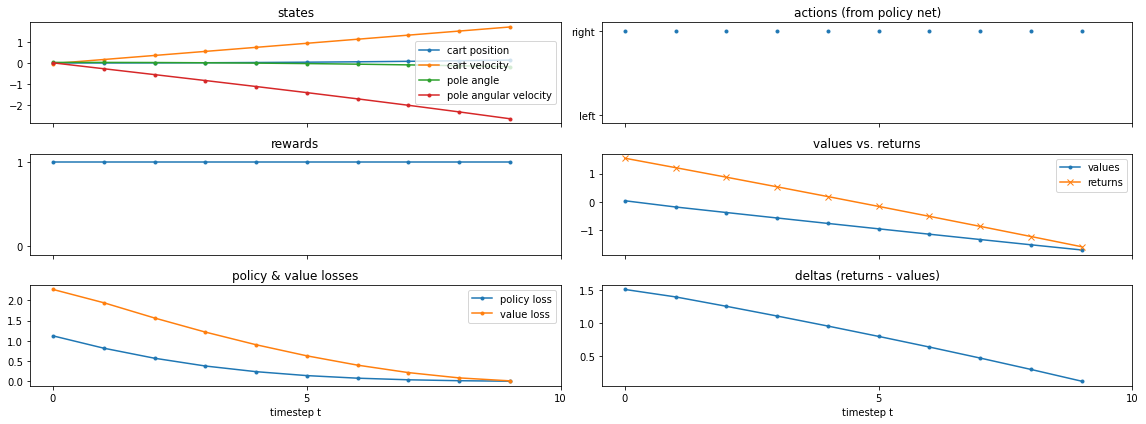

In [17]:
gamma = 0.99
seed_sequence = np.random.SeedSequence(6)

env = gym.make('CartPole-v1')

env.seed(seed_adapter(seed_sequence))
torch.manual_seed(seed_adapter(seed_sequence))

agent = REINFORCE_BL_Agent(env, policy_alpha=1e-3, value_alpha=1e-3)
episode = agent.generate_episode(env)
losses = agent.update(episode, gamma)
visualize_episode(gamma, episode, losses)

### The expected output of the previous cell should look exactly like this:
```
seed_int 10324823579957477319
seed_int 2479505222830176779
```
<img src='expected_bl_update_output.png'/>

### Making sure REINFORCE with baseline learns something useful
Let's train the REINFORCE with baseline agent for 200 episodes, and see what it has learned.

seed_int 3386250816931739734
seed_int 4042502035264064771


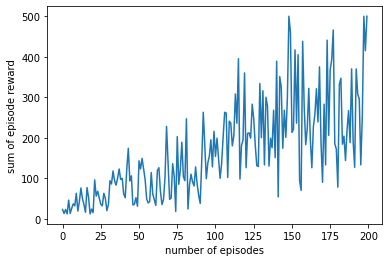

In [18]:
gamma = 0.99
seed_sequence = np.random.SeedSequence(7)

env = gym.make('CartPole-v1')
env.seed(seed_adapter(seed_sequence))

torch.manual_seed(seed_adapter(seed_sequence))
agent = REINFORCE_BL_Agent(env, policy_alpha=1e-3, value_alpha=1e-3)

episode_rewards = []
for i_episode in range(200):
    episode = agent.generate_episode(env)
    losses = agent.update(episode, gamma)
    episode_rewards.append(np.sum(episode['rewards']))

fig, ax = plt.subplots()
ax.set_ylabel('sum of episode reward')
ax.set_xlabel('number of episodes')
ax.plot(episode_rewards)
plt.show()

### The expected output of the previous cell should look exactly like this:
```
seed_int 3386250816931739734
seed_int 4042502035264064771
```
<img src='expected_bl_train_rewards.png'/>

### Let's look at a generated episode, after the agent has trained for 200 episodes:
This will be a different episode, and different behavior, each time you execute this cell.<br>
The reason is that `env` was seeded in a code cell above, and its internal PRNG state is advanced, as the agent is interacting with it.<br>
If you always want the same episode generated, you need to set the seed of the `env` in the code cell below.

In [ ]:
# i find it *really* funny that given this seed (2021 12 08), the agent trained above runs for the full 500 steps :)
seed_sequence = np.random.SeedSequence(20211208)

env = gym.make('CartPole-v1')

env.seed(seed_adapter(seed_sequence))
torch.manual_seed(seed_adapter(seed_sequence))

episode = agent.generate_episode(env)
visualize_episode(gamma, episode)

## (7) Run a comparison between REINFORCE and REINFORCE with Baseline (4 points)
Here, you will compare the performance of REINFORCE and REINFORCE with Baseline. Each algorithm needs to be run 7 times, for 500 episodes. All learn rates should be the `alpha` value given below, including `policy_alpha` and `value_alpha` for REINFORCE with Baseline.

In [ ]:
gamma = 0.99
seed_sequence = np.random.SeedSequence(7)

env = gym.make('CartPole-v1')

n_runs = 7
n_episodes = 500
alpha = 1e-2



In [ ]:
# my part - run REINFORCE:
reinforce_rewards = run_experiments(
        seed_sequence,  # reusing this makes sure each run has a different seed
        env,
        gamma,
        n_runs,
        n_episodes,
        REINFORCEAgent,
        agent_params=dict(
            env=env,
            alpha=alpha
        )
    )

In [ ]:
# my part - run REINFORCE with Baseline:
reinforce_bl_rewards = run_experiments(
        seed_sequence,  # reusing this makes sure each run has a different seed
        env,
        gamma,
        n_runs,
        n_episodes,
        REINFORCE_BL_Agent,
        agent_params=dict(
            env=env,
            policy_alpha=alpha,
            value_alpha=alpha
        )
    )

In [ ]:
fig, ax = plt.subplots()
plot(ax, reinforce_rewards, label='REINFORCE')
plot(ax, reinforce_bl_rewards, label='REINFORCE + BL')
ax.legend()
plt.show()

All plots before were accurate only this plot here isn't on point. Why is it like that?

### If everything went OK, the plot of the previous cell should look exactly like this:
<img src='expected_comparison.png'/>